<a href="https://colab.research.google.com/github/PhamBaVuong/PhamBaVuong_DATN/blob/main/yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 


# import useful tools
from glob import glob
from PIL import Image
import cv2

# import data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, output_file
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models.widgets import Tabs

from tqdm.auto import tqdm
import shutil as sh

# import data augmentation
import albumentations as albu

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Setup the paths to train and test images
train=pd.read_csv('/content/drive/MyDrive/train/train.csv')
test=pd.read_csv('/content/drive/MyDrive/train/test.csv')

Images='/content/drive/MyDrive/train/image_data/'
# Glob the directories and get the lists of train and test images
img = glob(Images + '*')

In [4]:
# Compute at the number of images:
print('Total Number of images is {}'.format(len(img)))

Total Number of images is 8196


In [5]:
print('Number of image in train data are {}'.format(train.shape[0]))
train.head()

Number of image in train data are 5733


,Name,HeadCount
0,10001.jpg,4
1,10002.jpg,4
2,10003.jpg,2
3,10004.jpg,3
4,10006.jpg,4


In [6]:
print('Number of image in test data are {}'.format(test.shape[0]))
test.head()

Number of image in test data are 2463


,Name
0,10005.jpg
1,10009.jpg
2,10015.jpg
3,10022.jpg
4,10023.jpg


In [7]:
bbox=pd.read_csv('/content/drive/MyDrive/train/bbox_train.csv')
bbox.head()

,Name,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,612,408,192,199,230,235
1,10001.jpg,612,408,247,168,291,211
2,10001.jpg,612,408,321,176,366,222
3,10001.jpg,612,408,355,183,387,214
4,10002.jpg,612,408,339,165,378,202


In [8]:
# Merge all train images with the bounding boxes dataframe

train_images = train.merge(bbox, on='Name', how='left')

In [9]:
print(train_images.isnull().sum())
print(train_images.shape)
train_images

Name         0
HeadCount    0
width        0
height       0
xmin         0
ymin         0
xmax         0
ymax         0
dtype: int64
(24533, 8)


,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202
...,...,...,...,...,...,...,...,...
24528,18205.jpg,8,612,425,9,52,52,116
24529,18207.jpg,4,475,612,160,149,241,226
24530,18207.jpg,4,475,612,226,47,277,104
24531,18207.jpg,4,475,612,113,41,179,106


In [10]:
### Let's plot some image examples:

train_images.iloc[2].Name

'10001.jpg'

In [11]:
# First we store all the box dimensions.
def get_all_bboxes(df, image_id):
    image_bboxes = df[df.Name == image_id]
    
    bboxes = []
    for _,row in image_bboxes.iterrows():
        bboxes.append((row.xmin, row.ymin, row.xmax, row.ymax))
        
    return bboxes

# function for box representation on the image.

def plot_image_with_box(df, rows=3, cols=4, title='Face count images'):
    fig, axs = plt.subplots(rows, cols, figsize=(20,15))
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            img_id = df.iloc[idx].Name
            
            img = Image.open(Images + img_id)
            axs[row, col].imshow(img)
            
            bboxes = get_all_bboxes(df, img_id)
            
            for bbox in bboxes:
                rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=2,edgecolor='g',facecolor='none')
                axs[row, col].add_patch(rect)
            
            axs[row, col].axis('off')
            
    plt.suptitle(title)

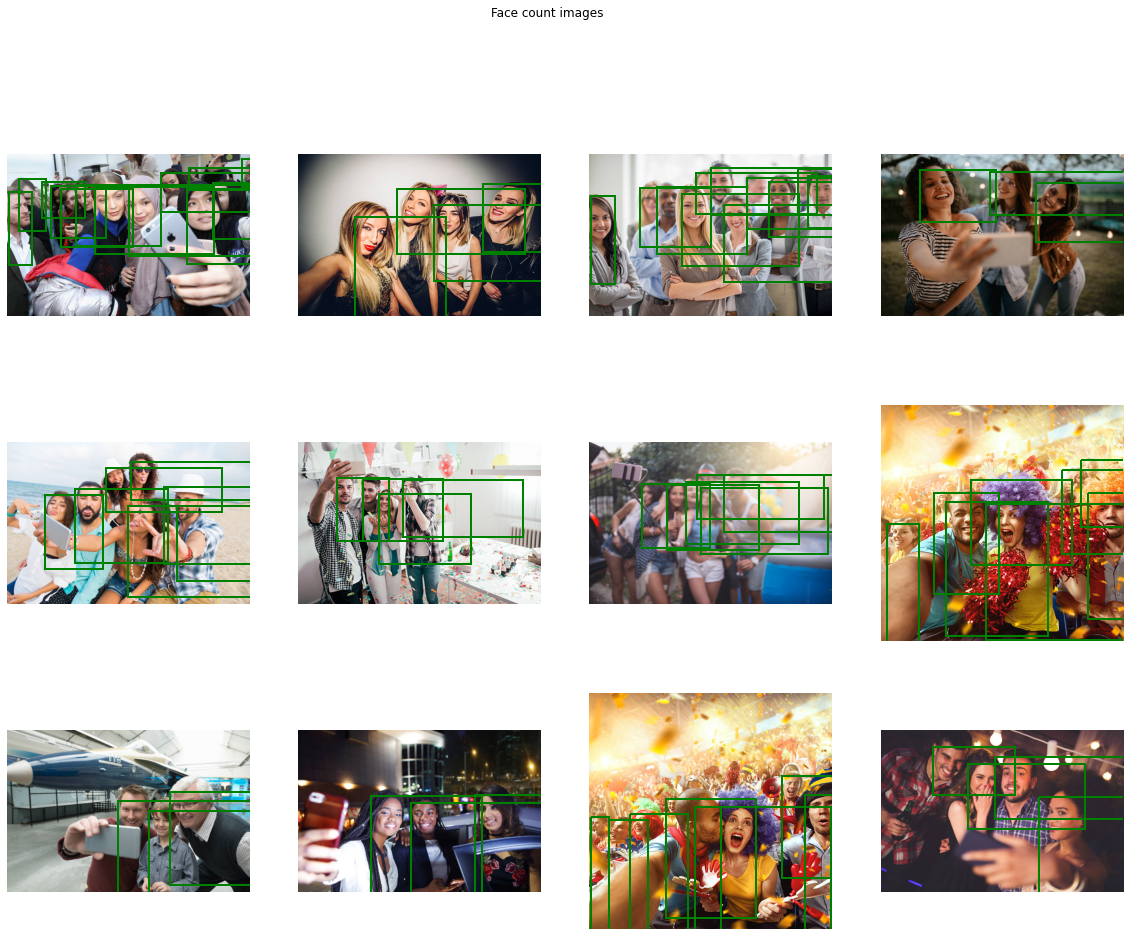

In [12]:
plot_image_with_box(train_images)

In [13]:
# compute the number of bounding boxes per train image
# train_images['count'] = train_images.loc[:,train_images.columns !='HeadCount'].apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)


# train_images_count = train_images.loc[:,train_images.columns !='HeadCount'].groupby('Name').sum().reset_index()

In [14]:
# train_images_count['HeadCount']=train['HeadCount']
# train_images_count.head()

In [15]:
# len(train_images_count.Name.unique())

In [16]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3

def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = 'Faces in image',
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [17]:
hist_hover(train_images, 'HeadCount', title='Number of faces per image')

In [18]:
train_images.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


In [19]:
df=train_images
df.head()

,Name,HeadCount,width,height,xmin,ymin,xmax,ymax
0,10001.jpg,4,612,408,192,199,230,235
1,10001.jpg,4,612,408,247,168,291,211
2,10001.jpg,4,612,408,321,176,366,222
3,10001.jpg,4,612,408,355,183,387,214
4,10002.jpg,4,612,408,339,165,378,202


In [20]:
df['x_center'] = df['xmin'] + df['width']/2
df['y_center'] = df['ymin'] + df['height']/2
df['classes'] = 0


df['image_id']=df['Name'].str.replace('.jpg','')

df = df[['image_id','xmin', 'ymin', 'width', 'height','x_center','y_center','classes']]

<ipython-input-20-4de48580ceca>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_id']=df['Name'].str.replace('.jpg','')


In [21]:
df.head()

,image_id,xmin,ymin,width,height,x_center,y_center,classes
0,10001,192,199,612,408,498.0,403.0,0
1,10001,247,168,612,408,553.0,372.0,0
2,10001,321,176,612,408,627.0,380.0,0
3,10001,355,183,612,408,661.0,387.0,0
4,10002,339,165,612,408,645.0,369.0,0


In [22]:
from IPython.display import Image, clear_output  # to display images

In [23]:
# import required dependencies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm.auto import tqdm
import shutil as sh

import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
!git clone https://github.com/AIVenture0/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 779, done.
remote: Total 779 (delta 0), reused 0 (delta 0), pack-reused 779
Receiving objects: 100% (779/779), 3.37 MiB | 30.80 MiB/s, done.
Resolving deltas: 100% (514/514), done.


In [26]:
# move all the files of YOLOv5 to current working directory
!mv yolov5/* ./

In [27]:
# check for all the files in the current working directory
!ls

data	    drive	LICENSE    requirements.txt  train.py	     weights
detect.py   hubconf.py	models	   sample_data	     tutorial.ipynb  yolov5
Dockerfile  inference	README.md  test.py	     utils


In [28]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-zvt4ey4a
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-zvt4ey4a
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 72.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [29]:
# # read the training data.


# df = pd.read_csv('../input/global-wheat-detection/train.csv')
# bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
# for i, column in enumerate(['x', 'y', 'w', 'h']):
#     df[column] = bboxs[:,i]
# df.drop(columns=['bbox'], inplace=True)
# df['x_center'] = df['x'] + df['w']/2
# df['y_center'] = df['y'] + df['h']/2
# df['classes'] = 0
# from tqdm.auto import tqdm
# import shutil as sh
# df = df[['image_id','x', 'y', 'w', 'h','x_center','y_center','classes']]

In [30]:
# count
index = list(set(df.image_id))
len(index)

5733

In [32]:
# code to transform the dataset.

source = 'train'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','width','height']].astype(float).values
                row = row/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy('/content/drive/MyDrive/{}/image_data/{}.jpg'.format(source,name),'convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

  0%|          | 0/5733 [00:00<?, ?it/s]

In [33]:
print(os.listdir("/content/drive/MyDrive/train"))

['bbox_train.csv', 'sample_submission.csv', 'test.csv', 'train.csv', 'image_data']


In [34]:
# !ls ./convertor

!ls ./convertor/fold0/labels/train2017/12433.txt

./convertor/fold0/labels/train2017/12433.txt


In [35]:
# As i am running it for just trial(To save training time and GPU ) 
# So i am considering all the training factors to a limited extent.

# Play with all featuers and see their performance.


# !python train.py --img 1024 --batch 20 --epochs 10 --data ../input/yaml-file-for-face-count-data-model/face_count.yaml --cfg ../input/yaml-file-for-face-count-data-model/yolov5x.yaml --name yolov5x_fold0_new


!python ./train.py --img 640 --batch 3 --epochs 20 --data ../input/yaml-file-for-face-count-data-model/face_count.yaml --cfg ../input/yaml-file-for-face-count-data-model/yolov5x.yaml --name yolov5x_fold0_new

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Traceback (most recent call last):
  File "/content/./train.py", line 391, in <module>
    opt.cfg = check_file(opt.cfg)  # check file
  File "/content/utils/utils.py", line 104, in check_file
    assert len(files), 'File Not Found: %s' % file  # assert file was found
AssertionError: File Not Found: ../input/yaml-file-for-face-count-data-model/yolov5x.yaml
